In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import osmnx as ox
import folium

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%pwd

'/home/cseadmin/data/cys/TrafficFlowModel/data_process'

In [3]:
map=folium.Map(location=[22.565050, 114.045616], 
               zoom_start=12, 
               tiles='Stamen Toner'
               )
n=10
file_path="../data/taxi_after_proc/merged/"

count=0
for taxi_file in os.listdir(file_path):
    if os.path.getsize(os.path.join(file_path, taxi_file))<100:
        continue
    
    df_taxi=pd.read_csv(os.path.join(file_path, taxi_file))
    gps_list=df_taxi[["lat", "lng"]].values.tolist()
    
    for gps in gps_list:
        trash=folium.Circle(gps, radius=20).add_to(map)

    count+=1
    if count>n:
        break
    
map

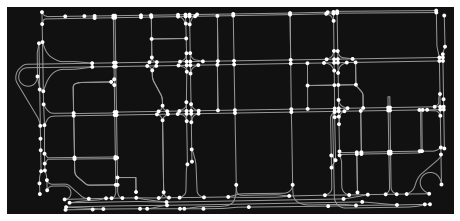

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

{'n': 248,
 'm': 408,
 'k_avg': 3.2903225806451615,
 'edge_length_total': 44613.61100000003,
 'edge_length_avg': 109.3470857843138,
 'streets_per_node_avg': 3.306451612903226,
 'streets_per_node_counts': {0: 0, 1: 2, 2: 0, 3: 166, 4: 80},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.008064516129032258,
  2: 0.0,
  3: 0.6693548387096774,
  4: 0.3225806451612903},
 'intersection_count': 246,
 'street_length_total': 41229.51400000003,
 'street_segment_count': 381,
 'street_length_avg': 108.21394750656177,
 'circuity_avg': 1.0468270863018474,
 'self_loop_proportion': 0.0}

In [3]:
# futian_graph_drive=ox.graph_from_bbox(22.5311, 22.5517, 114.0439, 114.0633, network_type="drive")
futian_graph_drive=ox.graph_from_bbox(22.5310, 22.5397, 114.0442, 114.0633, network_type="drive")
# futian_graph_drive=ox.graph_from_bbox(22.5311, 22.5377, 114.0442, 114.0633, network_type="drive")

ox.plot_graph(futian_graph_drive)
ox.basic_stats(futian_graph_drive)

In [14]:
futian_line_graph_drive=nx.line_graph(futian_graph_drive)

len(futian_line_graph_drive.nodes)

408

In [15]:
nx.write_gpickle(futian_graph_drive, path="../data/futian_graph_drive.pkl")
nx.write_gpickle(futian_line_graph_drive, path="../data/futian_line_graph_drive.pkl")

For FMM

---

In [10]:
# @deprecated
# ox.io.save_graph_shapefile(futian_graph_drive, filepath="../data/fmm_data", directed=True)

/home/cseadmin/data/cys/anaconda3/envs/dz/lib/python3.8/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


In [12]:
def save_graph_shapefile_directional(G, filepath=None, encoding="utf-8"):
    # default filepath if none was provided
    if filepath is None:
        filepath = os.path.join(ox.settings.data_folder, "graph_shapefile")

    # if save folder does not already exist, create it (shapefiles
    # get saved as set of files)
    if not filepath == "" and not os.path.exists(filepath):
        os.makedirs(filepath)
    filepath_nodes = os.path.join(filepath, "nodes.shp")
    filepath_edges = os.path.join(filepath, "edges.shp")

    # convert undirected graph to gdfs and stringify non-numeric columns
    gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
    gdf_nodes = ox.io._stringify_nonnumeric_cols(gdf_nodes)
    gdf_edges = ox.io._stringify_nonnumeric_cols(gdf_edges)
    
    # We need an unique ID for each edge
    # gdf_edges["fid"] = gdf_edges.index.to_numpy()
    gdf_edges["fid"] = np.arange(gdf_edges.shape[0]) # https://github.com/cyang-kth/fmm/issues/166
    
    # save the nodes and edges as separate ESRI shapefiles
    gdf_nodes.to_file(filepath_nodes, encoding=encoding)
    gdf_edges.to_file(filepath_edges, encoding=encoding)
    
save_graph_shapefile_directional(futian_graph_drive, filepath="../data/fmm_data")

/tmp/ipykernel_47745/3474539543.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, encoding=encoding)


In [13]:
import geopandas as gp
shp = gp.GeoDataFrame.from_file("../data/fmm_data/edges.shp")

shp

u           v  key      osmid  oneway lanes       highway  \
0     296024760  6033481369    0  640465230       1     1    trunk_link   
1     409392019  6033481329    0   40971705       1     4       primary   
2     499236929   499264828    0   40971702       1  None  primary_link   
3     499237442   499256522    0  684241517       1  None    trunk_link   
4     499237442  7232025523    0  328724256       1  None         trunk   
..          ...         ...  ...        ...     ...   ...           ...   
403  8516154911  8516154889    0   26274669       1     4       primary   
404  8516154912  8516154910    0   41019601       1     4       primary   
405  8869146293  7558081682    0   26274669       1     4       primary   
406  8869146293  7959990521    0  617224846       1     2      tertiary   
407  8875446876  7791604198    0   41018945       1  None  primary_link   

      length    name maxspeed access   ref tunnel bridge  fid  \
0    165.507    None     None   None  None   None   None    0   
1     47.579  滨河大道辅路       40    yes  None   None   None    1   
2     58.461    None     None   None  None   None   None    2   
3    177.073    None     None   None  None   None   None    3   
4    478.781    滨河大道     None   None  S550   None   None    4   
..       ...     ...      ...    ...   ...    ...    ...  ...   
403  156.629     彩田路     None   None  None   None   None  403   
404   16.481     彩田路     None   None  None   None   None  404   
405   33.430     彩田路     None   None  None   None   None  405   
406   93.933    福华五路     None   None  None   None   None  406   
407   37.239    None     None   None  None   None   None  407   

                                              geometry  
0    LINESTRING (114.05928 22.53152, 114.05977 22.5...  
1    LINESTRING (114.06133 22.53186, 114.06087 22.5...  
2    LINESTRING (114.04445 22.53283, 114.04441 22.5...  
3    LINESTRING (114.04560 22.53130, 114.04732 22.5...  
4    LINESTRING (114.04560 22.53130, 114.04758 22.5...  
..                                                 ...  
403  LINESTRING (114.06284 22.53753, 114.06284 22.5...  
404  LINESTRING (114.06300 22.53753, 114.06300 22.5...  
405  LINESTRING (114.06291 22.53384, 114.06291 22.5...  
406  LINESTRING (114.06291 22.53384, 114.06279 22.5...  
407  LINESTRING (114.06300 22.53782, 114.06301 22.5...  

[408 rows x 16 columns]